In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

In [2]:
# 1. LOAD & PREPARE ─────────────────────────────────────────
df = pd.read_csv(
    'training.1600000.processed.noemoticon.csv',
    encoding='latin-1',
    header=None,
    names=['target','id','date','flag','user','text'],
)

In [3]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.drop_duplicates(subset="id", inplace=True)

In [5]:
# drop the PDT token
df['date_clean'] = df['date'].str.replace(r' [A-Z]{3,4} ', ' ', regex=True)

# parse by format
df['date_parsed'] = pd.to_datetime(
    df['date_clean'],
    format='%a %b %d %H:%M:%S %Y',  # e.g. Mon Apr 06 22:19:49 2009
    errors='coerce'
)


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1598315 entries, 0 to 1599999
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   target       1598315 non-null  int64         
 1   id           1598315 non-null  int64         
 2   date         1598315 non-null  object        
 3   flag         1598315 non-null  object        
 4   user         1598315 non-null  object        
 5   text         1598315 non-null  object        
 6   date_clean   1598315 non-null  object        
 7   date_parsed  1598315 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 109.7+ MB
None


In [7]:
print(df['target'].value_counts(normalize=True))

target
0    0.500527
4    0.499473
Name: proportion, dtype: float64


<Axes: title={'center': 'Tweets per day'}, xlabel='date_parsed'>

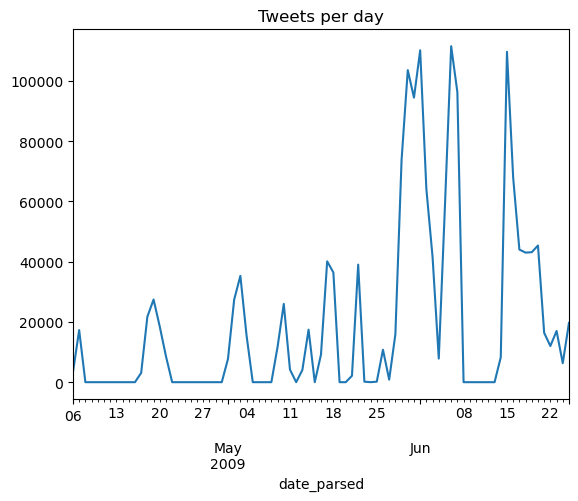

In [8]:
# Drop rows that still failed
df = df[df['date_parsed'].notna()]

# Now you can resample, extract .dt.hour/.dayofweek/.month, etc.
tweets_per_day = (
    df
    .set_index('date_parsed')
    .resample('D')
    .id.count()
)
tweets_per_day.plot(title="Tweets per day")


<Axes: title={'center': 'word_count'}, xlabel='target'>

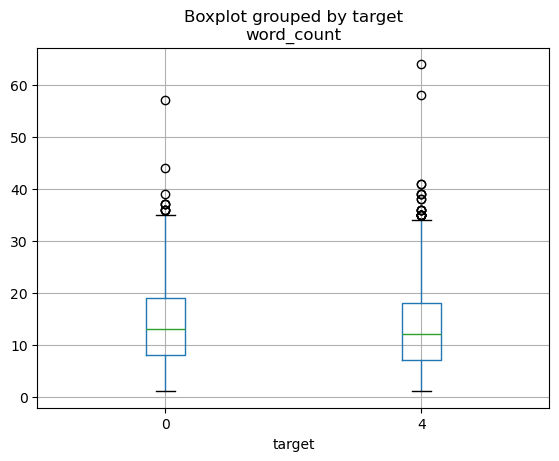

In [9]:
# 4. Text length analysis
df['char_count'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().apply(len)
df.boxplot(column='word_count', by='target')

In [10]:
# 5. Word frequencies
from collections import Counter
all_words = Counter(" ".join(df['text']).lower().split())
print(all_words.most_common(20))

[('i', 745489), ('to', 559575), ('the', 518095), ('a', 376001), ('my', 312463), ('and', 295312), ('you', 237417), ('is', 230801), ('for', 213759), ('in', 209661), ('it', 190767), ('of', 182377), ('on', 161375), ('so', 145551), ('have', 143027), ('that', 128637), ('me', 128329), ("i'm", 127434), ('just', 124306), ('but', 124271)]


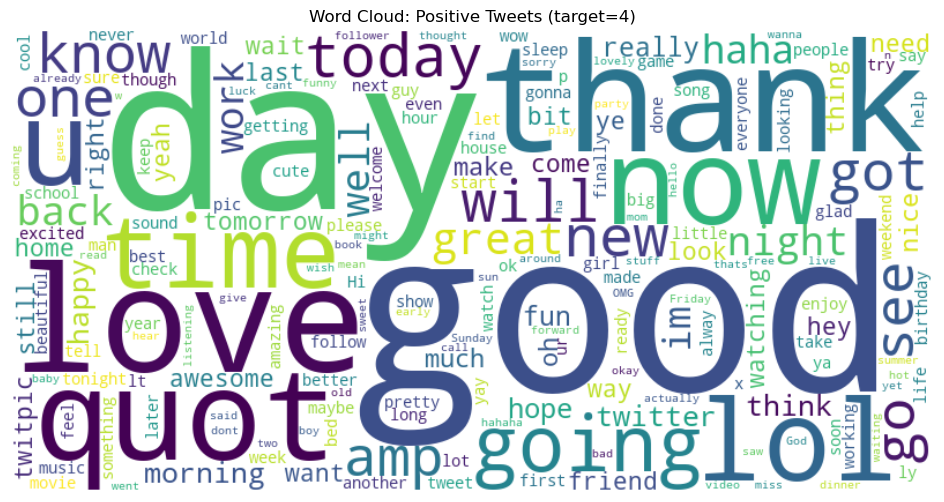

In [11]:
# 6. Word cloud for positives

pos_text = " ".join(df.loc[df['target']==4, 'text'].dropna().astype(str))
wc = WordCloud(
    background_color='white',
    width=800, 
    height=400,
    collocations=False
).generate(pos_text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Positive Tweets (target=4)")
plt.show()

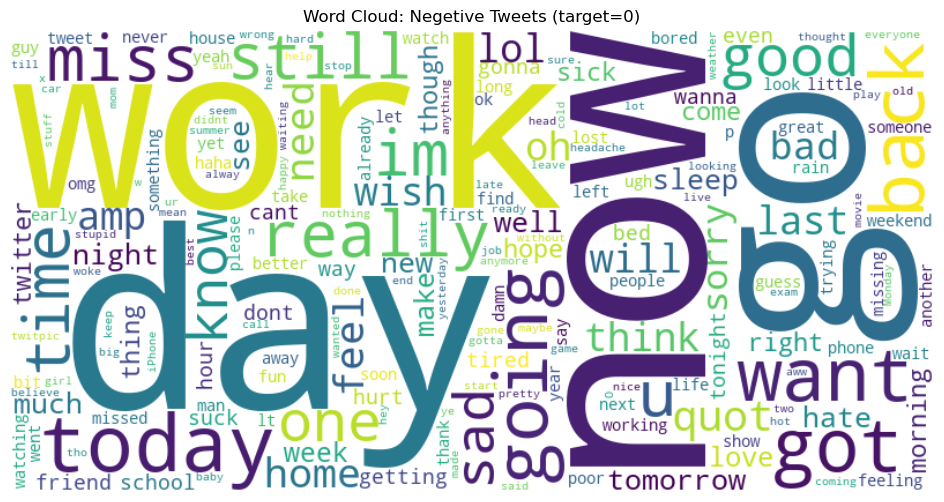

In [12]:
# 7. Word cloud for Negetive

pos_text = " ".join(df.loc[df['target']==0, 'text'].dropna().astype(str))
wc = WordCloud(
    background_color='white',
    width=800, 
    height=400,
    collocations=False
).generate(pos_text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Negetive Tweets (target=0)")
plt.show()

In [13]:
# ────────────────────────────────────────────────────────────
# 5. DATE-DERIVED FEATURES
# ────────────────────────────────────────────────────────────
# extract granular features
df['year']    = df['date_parsed'].dt.year
df['month']   = df['date_parsed'].dt.month
df['day']     = df['date_parsed'].dt.day
df['weekday'] = df['date_parsed'].dt.day_name()
df['hour']    = df['date_parsed'].dt.hour

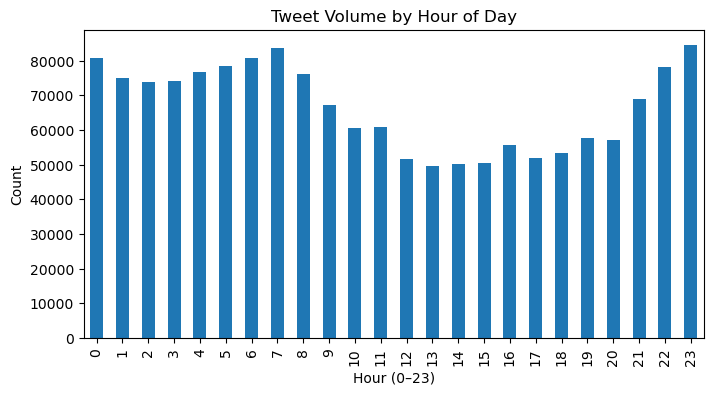

In [14]:
# plot tweets by hour
plt.figure(figsize=(8,4))
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title("Tweet Volume by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Count")
plt.show()

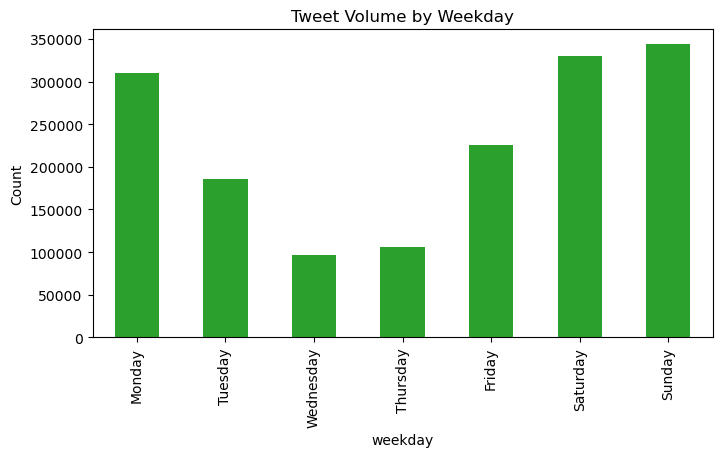

In [15]:
# plot tweets by weekday
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(8,4))
df['weekday'].value_counts().reindex(weekday_order).plot(kind='bar', color='C2')
plt.title("Tweet Volume by Weekday")
plt.ylabel("Count")
plt.show()

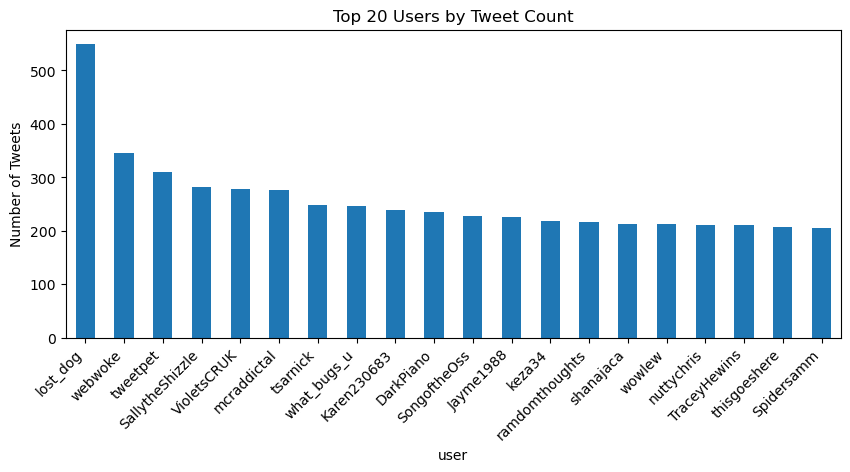

In [16]:
# ────────────────────────────────────────────────────────────
# 6. USER-LEVEL AGGREGATES
# ────────────────────────────────────────────────────────────
# a) Top 20 users by tweet count
top_users = df['user'].value_counts().head(20)
plt.figure(figsize=(10,4))
top_users.plot(kind='bar')
plt.title("Top 20 Users by Tweet Count")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45, ha='right')
plt.show()

In [17]:
# b) % of "power users" with >100 tweets
user_counts = df['user'].value_counts()
pct_power = (user_counts > 100).sum() / user_counts.shape[0] * 100
print(f"{pct_power:.2f}% of users authored more than 100 tweets.")

0.02% of users authored more than 100 tweets.


In [18]:
# c) Average sentiment per user
sent_by_user = df.groupby('user')['target'].mean()
print("5 users with lowest avg sentiment:", sent_by_user.nsmallest(5))
print("5 users with highest avg sentiment:", sent_by_user.nlargest(5))

5 users with lowest avg sentiment: user
006jazzy       0.0
007LouiseOB    0.0
007buddha      0.0
007robbo       0.0
007simple      0.0
Name: target, dtype: float64
5 users with highest avg sentiment: user
000matthewkelly    4.0
000yea000          4.0
0010x0010          4.0
001BabyGirl        4.0
001trish           4.0
Name: target, dtype: float64


In [19]:
# ────────────────────────────────────────────────────────────
# 7. LEXICAL ANALYSIS
# ────────────────────────────────────────────────────────────
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
# download stopwords once
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashwanthreddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# tokenize & remove stopwords
df['tokens'] = (df['text']
                .str.lower()
                .str.findall(r'\b\w+\b')
                .apply(lambda toks: [t for t in toks if t not in stop]))

# overall top 20 words
all_words = Counter(w for toks in df['tokens'] for w in toks)
print("Overall Top 20 Words:", all_words.most_common(20))

Overall Top 20 Words: [('good', 91208), ('day', 86940), ('get', 81922), ('like', 78496), ('go', 73824), ('quot', 72034), ('http', 71535), ('today', 68078), ('work', 64903), ('love', 64578), ('going', 64530), ('got', 61181), ('lol', 59153), ('time', 57858), ('back', 56822), ('u', 55762), ('one', 53860), ('com', 52596), ('im', 52146), ('know', 51972)]


In [22]:
# top 10 words per sentiment
for sentiment in sorted(df['target'].unique()):
    cw = Counter(w for toks in df.loc[df['target']==sentiment,'tokens'] for w in toks)
    print(f"Sentiment={sentiment} Top 10:", cw.most_common(10))

Sentiment=0 Top 10: [('go', 45582), ('get', 45542), ('work', 45455), ('like', 41048), ('day', 39858), ('today', 38115), ('going', 33685), ('got', 33289), ('back', 33076), ('really', 31497)]
Sentiment=4 Top 10: [('good', 62001), ('love', 47588), ('http', 47175), ('day', 47082), ('quot', 45858), ('like', 37448), ('get', 36380), ('lol', 36018), ('com', 35433), ('thanks', 34488)]


In [23]:
# top 20 bigrams & trigrams (regardless of class)
ngram_vect = CountVectorizer(ngram_range=(2,3),
                             stop_words='english',
                             max_features=20)
ngram_vect.fit(df['text'].fillna(''))
print("Top 20 n-grams:", ngram_vect.get_feature_names_out())

Top 20 n-grams: ['bit ly' 'don know' 'feel like' 'getting ready' 'good luck'
 'good morning' 'http bit' 'http bit ly' 'http plurk' 'http plurk com'
 'http tinyurl' 'http tinyurl com' 'http twitpic' 'http twitpic com'
 'just got' 'looking forward' 'looks like' 'plurk com' 'tinyurl com'
 'twitpic com']


In [24]:
# ────────────────────────────────────────────────────────────
# 8. ADVANCED EXPLORATIONS: LDA TOPIC MODELING
# ────────────────────────────────────────────────────────────
from sklearn.decomposition import LatentDirichletAllocation

# vectorize text to document-term matrix
vect = CountVectorizer(max_df=0.95,
                       min_df=50,
                       stop_words='english')
dtm = vect.fit_transform(df['text'].fillna(''))

# fit LDA
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics,
                                random_state=42,
                                learning_method='batch')
lda.fit(dtm)

# show top terms per topic
terms = vect.get_feature_names_out()
for idx, comp in enumerate(lda.components_):
    top_terms = [terms[i] for i in comp.argsort()[-10:][::-1]]
    print(f"Topic {idx}: {', '.join(top_terms)}")


Topic 0: need, twitter, going, tomorrow, today, getting, ll, sleep, time, day
Topic 1: just, got, work, im, home, lol, want, going, today, tonight
Topic 2: good, love, thanks, hope, great, day, know, happy, sorry, like
Topic 3: quot, just, bit, watching, like, ly, day, days, movie, amp
Topic 4: http, com, twitpic, oh, yes, like, look, new, just, does


                target  char_count  word_count  avg_word_len
target        1.000000   -0.006454   -0.059056      0.157132
char_count   -0.006454    1.000000    0.954625     -0.138396
word_count   -0.059056    0.954625    1.000000     -0.353784
avg_word_len  0.157132   -0.138396   -0.353784      1.000000


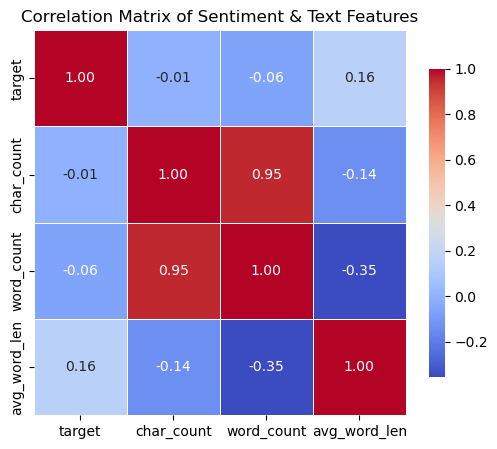

In [25]:
# 9. CORRELATION MATRIX ────────────────────────────────────────
import seaborn as sns

# 7a) Create some simple numeric features
df['char_count']    = df['text'].str.len()                                 # total characters
df['word_count']    = df['text'].str.split().str.len()                     # total words
df['avg_word_len']  = df['char_count'] / df['word_count'].replace(0,1)     # average word length

# 9b) Select the numeric columns for correlation
num_cols = ['target', 'char_count', 'word_count', 'avg_word_len']
corr_df  = df[num_cols].corr()

# 9c) Display the raw correlation matrix
print(corr_df)

# 9d) Plot a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
    cbar_kws={"shrink":0.8}
)
plt.title("Correlation Matrix of Sentiment & Text Features")
plt.show()


In [26]:
# BUILD ANALYTICS BASE TABLE ─────────────────────────────────────────
abt = df.copy()

# length of each tweet
abt['text_length'] = abt['text'].str.len()

# number of words per tweet
abt['num_words'] = abt['text'].str.split().str.len()

# count of hashtags (#word) and mentions (@user)
abt['num_hashtags'] = abt['text'].str.count(r'#\w+')
abt['num_mentions'] = abt['text'].str.count(r'@\w+')

# flag for presence of a URL
abt['has_url'] = abt['text'].str.contains(r'https?://', regex=True).astype(int)

# unique-word ratio (vocabulary richness)
abt['unique_word_ratio'] = (
    abt['text']
       .str.lower()
       .str.split()
       .apply(lambda w: len(set(w)) / len(w) if w else 0)
)

# map target to a human-friendly label
abt['sentiment_label'] = abt['target'].map({0:'negative', 2:'neutral', 4:'positive'})

# Date/time features
abt['hour']       = abt['date_parsed'].dt.hour
abt['day_of_week']= abt['date_parsed'].dt.dayofweek      # Monday=0…Sunday=6
abt['month']      = abt['date_parsed'].dt.month

# Quick sanity check
print("ABT shape:", abt.shape)
display(abt.head())


ABT shape: (1598315, 25)


,target,id,date,flag,user,text,date_clean,date_parsed,char_count,word_count,...,tokens,avg_word_len,text_length,num_words,num_hashtags,num_mentions,has_url,unique_word_ratio,sentiment_label,day_of_week
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Mon Apr 06 22:19:45 2009,2009-04-06 22:19:45,115,19,...,"[switchfoot, http, twitpic, com, 2y1zl, awww, ...",6.052632,115,19,0,1,1,1.000000,negative,0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Mon Apr 06 22:19:49 2009,2009-04-06 22:19:49,111,21,...,"[upset, update, facebook, texting, might, cry,...",5.285714,111,21,0,0,0,1.000000,negative,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Mon Apr 06 22:19:53 2009,2009-04-06 22:19:53,89,18,...,"[kenichan, dived, many, times, ball, managed, ...",4.944444,89,18,0,1,0,0.944444,negative,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Mon Apr 06 22:19:57 2009,2009-04-06 22:19:57,47,10,...,"[whole, body, feels, itchy, like, fire]",4.700000,47,10,0,0,0,1.000000,negative,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Mon Apr 06 22:19:57 2009,2009-04-06 22:19:57,111,21,...,"[nationwideclass, behaving, mad, see]",5.285714,111,21,0,1,0,0.952381,negative,0
